# COMP-7950 - Advanced Machine Learning - Project

## Instructions

| Date set     | Hand-in date |
|------------------|-----------------------------------|
|22nd February 2021  | **18th April 2021** |



Student ID: 7779598 

Your report should consist of your Jupyter notebook showing what you did (including technical descriptions of the implemented algorithms), what was the result and what you can conclude from the experiments. Each report will be
assessed on the following criteria:

* Does it record what was done including the details of the implemented algorithms?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Use markdown to explain what you are doing (including equations for models and algorithms), what the results mean, how they relate to the theory, etc. For learning features of jupyter notebooks, you might refer to this guide: https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook

### Submitting the notebooks

Only an electronic submission is required. Submit your notebook (the .ipynb file) via e-mail to [lorenzo.livi@umanitoba.ca](mailto:lorenzo.livi@umanitoba.ca).
You should be able to upload the notebook directly from wherever it is on your machine. If you are not sure where it is, type <code>pwd</code> (print working directory) in a cell to find out. To keep the marking anonymous, please do not leave directory names that reveal your identity in cells.

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively, these are individual exercises. The reports you write should be about the results **you** obtained, and your attention is drawn to the University guidelines on collaboration and plagiarism. 

## Project specification

The project is worth 50% of the final mark associated with the course. The project consists of two parts, which will be equally weighted.

- **Part 1 of the project**

Implement a standard echo state network (ESN) model operating with the feedback of the output. Implement training (i.e. optimization) of the read-out weights by means of the regularized least-square method (i.e. ridge regression) discussed in class. With your implementation, perform simulations on the **flip-flop task** described in the following two references:
1. Ceni et al. Interpreting Recurrent Neural Networks Behaviour via Excitable Network Attractors. Cognitive Computation, 2019
2. Section 3.3 of Sussillo and Barak. Opening the Black Box: Low-Dimensional Dynamics in High-Dimensional Recurrent Neural Networks. Neural Computation, 2013

Perform simulations with 2, 3, and 4 input/output bits for the flip-flop tasks and comments on the results by varying hyperparameters and other settings.

- **Part 2 of the project**

Implement the *online* training algorithm known as FORCE learning. The algorithm was originally introduced in "Sussillo and Abbott, *Generating Coherent Patterns of Activity from Chaotic Neural Networks*, Neuron 2009". The supplementary material of that paper provides access to a matlab implementation of the algorithm, which you might use as a starting point for your own implementation. You should optimize the read-out weights only (as for Part 1 of the project), however implementations of FORCE learning that optimize additional weights (e.g. the recurrent layer and/or the output feedback connections) are permitted. Perform simulations with the resulting online ESN model on the same flip-flop tasks considered in Part 1 (i.e. with 2, 3, and 4 input/output bits) and draw some conclusions on the main differences between the two approaches.

## Your project starts from here!

In [ ]:
import matplotlib.pyplot as plt
# make sure plots are displayed correctly on notebooks
%matplotlib inline

### Part 1 of the project...

In [ ]:
#@title parameters
import numpy as np
import random

num_bits = 2
num_samples = 3000
seq_length = 1000
training_percentage = 0.8
regularizer = 0.1
prob = 0.2  # probability for flipping bit to occur

reservoir_neurons = 1000

noise = 0.01
spectral_radius = 0.01



In [ ]:
#@title create flip-flop dataset



def create_dataset(num_bits):
    """
    Create the dataset for the flip-flop tasks
    :param num_bits: The number of bits in the flip-flop task

    :return:
    X train, Y train, X test, Y test
    """
    X = np.zeros([seq_length, num_bits])
    Y = np.zeros([seq_length, num_bits])

    # create random positive/negative bit positions for the X values
    for current_bit in range(num_bits):
        # generate the index of the positive/negative bit positions
        positive_flips = np.random.uniform(0, seq_length - 1, [int(seq_length * prob / 2)]).astype(np.int32)
        negative_flips = np.random.uniform(0, seq_length - 1, [int(seq_length * prob / 2)]).astype(np.int32)
        # assign the positive/negative bits
        X[positive_flips, current_bit] = 1
        X[negative_flips, current_bit] = -1
    Y[0] = np.random.choice([-1, 1], [num_bits])
    # start Y randomly

    # do the y values
    # Get correct output
    state = np.zeros([num_bits])
    for n, x in enumerate(X):
        for idx, current_bit in enumerate(x):
            if current_bit == 1 or current_bit == -1:
                state[idx] = current_bit
        Y[n] = state

    # assign training and testing splits
    train_index = int(X.shape[0] * training_percentage)
    X_train = X[:train_index]
    Y_train = Y[:train_index]
    X_test = X[train_index:]
    Y_test = Y[train_index:]

    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = create_dataset(num_bits)

In [ ]:
#@title create the echo state network weights
def create_esn_weights(num_bits):
    input_size = num_bits
    output_size = num_bits
    # create randomly uniform distributed values between -0.5 to 0.5 for the weights of the ESN network
    input_weights = np.random.uniform(-0.5, 0.5, [reservoir_neurons, input_size+1]) # input size + 1 because we include the bias value too
    re_weights = np.random.uniform(-0.5, 0.5, [reservoir_neurons, reservoir_neurons])
    feedback_weights = np.random.uniform(-0.5, 0.5, [reservoir_neurons, output_size])

    # sparsity
    re_weights[np.random.rand(*re_weights.shape) > 0.2] = 0.0

    # normalize and set spectral radius
    # spectral radius is used to determine how long information would persist in the network before it decays
    # large spectral radius means information decay slower
    rho_w = max(abs(np.linalg.eigvals(re_weights)))
    re_weights = re_weights * spectral_radius / rho_w

    return input_weights, re_weights, feedback_weights



In [ ]:
#@title define the training and the prediction function for echo state network
def fit(inputs, outputs, input_weights, re_weights, feedback_weights):

    # create the states of the esn network +1 for the bias value
    states = np.zeros((inputs.shape[0], reservoir_neurons+1+inputs.shape[-1]))
    state = np.zeros((reservoir_neurons)) # each state contain the number of reservoir neurons
    for t in range(1, inputs.shape[0]):

        weighted_input = input_weights @ np.hstack((1, inputs[t]))
        weighted_state = re_weights @ state
        weighted_fb = feedback_weights @ outputs[t-1] # open loop, fed with the actual target

        # just like equation 23 in ESN lecture notes (page 50)
        state = np.tanh(weighted_input + weighted_state + weighted_fb) + noise * (np.random.rand(reservoir_neurons) - 0.5)
        states[t, :] = np.hstack((1, inputs[t], state))

    extended_states = states[100:]
    fitted_outputs = outputs[100:]

    # calculate the weight output for the esn network
    Wout = (np.linalg.pinv(extended_states.T @ extended_states + regularizer **2) @ extended_states.T @ fitted_outputs).T

    predictions = Wout @ extended_states.T
    loss = np.sum(np.square(predictions.T - outputs[100:]), 0) / outputs[100:].shape[0] # calculate the mean squared error loss
    return Wout, predictions, np.round(np.mean(loss), 3)


def predict(inputs, targets, input_weights, re_weights, feedback_weights, Wout):
    last_state = np.zeros((reservoir_neurons))
    all_outputs = np.zeros((inputs.shape[0], targets.shape[-1]))

    last_output = np .zeros((targets.shape[-1]))
    for t in range(inputs.shape[0]):
        weighted_input = input_weights @ np.hstack((1, inputs[t]))
        weighted_state = re_weights @ last_state
        weighted_fb = feedback_weights @ last_output # close loop, fed with the predicted target

        last_state = np.tanh(weighted_input + weighted_state + weighted_fb) + noise * (np.random.rand(reservoir_neurons) - 0.5)
        extended_state = np.hstack((1, inputs[t], last_state))
        last_output = Wout @ extended_state
        all_outputs[t] = last_output

    loss = np.sum(np.square(all_outputs - targets), 0) / targets.shape[0]
    return all_outputs, np.round(np.mean(loss), 3)


===echo state network without FORCE===
training loss: 0.021
training prediction


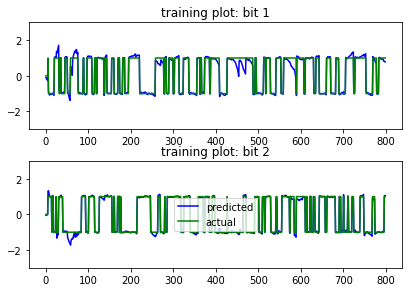

testing loss: 0.016
testing prediction


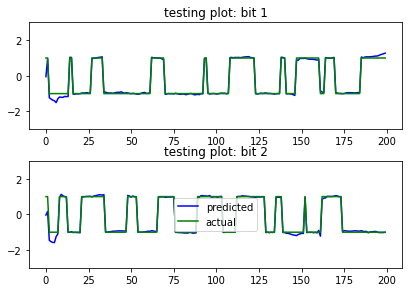

===echo state network without FORCE===
training loss: 0.135
training prediction


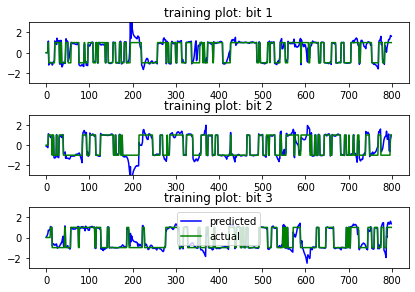

testing loss: 0.141
testing prediction


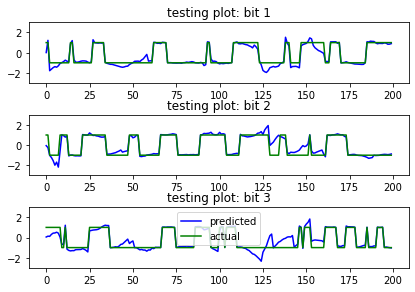

===echo state network without FORCE===
training loss: 1.292
training prediction


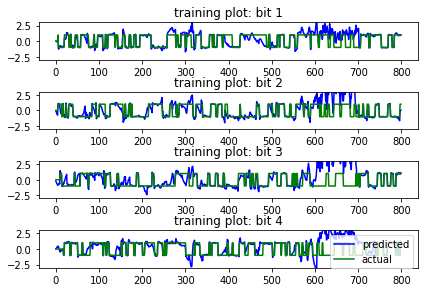

testing loss: 1.519
testing prediction


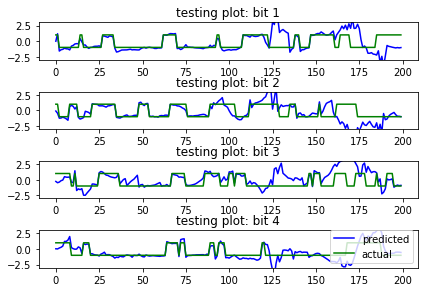

In [ ]:
#@title train and plot the training prediction and the testing prediction

for num_bits in range(2, 5):
  np.random.seed(42)
  random.seed(42)
  X_train, Y_train, X_test, Y_test = create_dataset(num_bits)
  input_weights, re_weights, feedback_weights = create_esn_weights(num_bits)


  print(f'===echo state network without FORCE===')
  # training
  Wout, _, _ = fit(X_train, Y_train, input_weights, re_weights, feedback_weights)
  predictions, training_loss = predict(X_train, Y_train, input_weights, re_weights, feedback_weights, Wout)

  fig, ax = plt.subplots(num_bits)
  fig.tight_layout()

  # fix error when there is only 1 plot then it's not an array
  if num_bits == 1:
      ax = [ax]

  print(f'training loss: {training_loss}')
  print(f'training prediction')
  for i in range(num_bits):
    ax[i].set_title(f'training plot: bit {i+1}')
    predict_plot = ax[i].plot(range(X_train.shape[0]), predictions[:, i], color='b', label='predicted')
    orig_plot = ax[i].plot(range(X_train.shape[0]), Y_train[:, i], color='g', label='actual')
    ax[i].set_ylim([-3, 3])
  plt.legend()
  plt.savefig(f'training without force: number of bits is {num_bits}')
  plt.show()

  # testing
  predictions, test_loss = predict(X_test, Y_test, input_weights, re_weights, feedback_weights, Wout)
  fig, ax = plt.subplots(num_bits)
  fig.tight_layout()

  # fix error when there is only 1 plot then it's not an array
  if num_bits == 1:
      ax = [ax]

  print(f'testing loss: {test_loss}')
  print(f'testing prediction')
  for i in range(num_bits):
    ax[i].set_title(f'testing plot: bit {i+1}')
    predict_plot = ax[i].plot(range(X_test.shape[0]), predictions[:, i], color='b', label='predicted')
    orig_plot = ax[i].plot(range(X_test.shape[0]), Y_test[:, i], color='g', label='actual')
    ax[i].set_ylim([-3, 3])
  plt.legend()
  plt.savefig(f'testing without force: number of bits is {num_bits}')
  plt.show()

### Evaluation on ESN without FORCE learning



---

We first create the dataset of flip flop tasks. We then create the ESN network weights. The ESN network consists of 3 different weights:
* input weights
* reservoir weights
* feedback weights

The input weights would attend to the input, reservoir weights would attend to the previous state, feedback weights would attend to the previous output.

For this algorithm, we will be doing open loop training and close loop testing. Due to the nature of open loop, we provided some noise to generate the next state of the echo state network to prevent the network from strongly memorizing the target of the output as testing process would require the echo state network to receive feedbacks from its generated previous output rather than the actual target output.

Spectral radius of the hyperparameter of echo state network is the maximum of all eigenvalues of the reservoir weights. It plays an important role in maintaining the stability of the ESN model and has the capability to impact memory of the past inputs. In this table, a test of different spectral radius on how they affect the training and testing performance of the flip-flop task dataset with number of bits (2, 3, 4).

The reservoir neurons is kept at 500. For all cases the regularizing constant is kept at 0.1.

**Changing spectral radius constant: reservoir neurons is 500**

| num bits | spectral radius | Training performance | Testing performance |
| :- | :- | :- | :- |
|  |  |  |  |
| 2 | 0.01 | 0.095 | 0.091 |
| 3 | 0.01 | 6.439 | 3.556 |
| 4 | 0.01 | 8.58 | 4.386 |
|  |  |  |  |
| 2 | 0.1 | 8.322 | 3.433 |
| 3 | 0.1 | 28.003 | 20.795 |
| 4 | 0.1 | 3.197 | 2.88 |
|  |  |  |  |
| 2 | 0.3 | 15.591 | 5.489 |
| 3 | 0.3 | 13.962 | 15.611 |
| 4 | 0.3 | 20.582 | 16.334 |
|  |  |  |  |
| 2 | 0.5 | 4.042 | 0.163 |
| 3 | 0.5 | 39.072 | 23.969 |
| 4 | 0.5 | 19.091 | 21.611 |
|  |  |  |  |
| 2 | 1 | 35.847 | 26.435 |
| 3 | 1 | 5.116 | 5.549 |
| 4 | 1 | 3.087 | 2.762 |
|  |  |  |  |
| 2 | 2 | 1.502 | 1.586 |
| 3 | 2 | 1.422 | 1.689 |
| 4 | 2 | 1.585 | 1.772 |

We can see that among the 5 values of spectral radius (0.01, 0.1, 0.3, 0.5, 1), spectral radius with value of 2 performs the best. It seems for this dataset that spectral radius with a bigger value have a more stability prediction than spectral radius with smaller values. 

However when we look at the plot for spectral radius of 0.01, this is what it is showing:

<img src="https://i.ibb.co/b1GVf4H/testing-without-force-number-of-bits-is-4.png" width="400" />

but with spectral radius of 20, this is what we have:

<img src="https://i.ibb.co/BtTrt0M/testing-without-force-number-of-bits-is-4.png" width="400" /> 




It seems like the higher the spectral radius the more vary/chaotic the prediction of echo state network will be.

Let's test see see what happens with the test performance when we vary the spectral radius hyperparameter with reservoir neurons to 1000. This is what we have:

**changing spectral radius constant: reservoir neurons is 1000**

| num bits | spectral radius | Training performance | Testing performance |
| :- | :- | :- | :- |
|  |  |  |  |
| 2 | 0.01 | 0.045 | 0.051 |
| 3 | 0.01 | 0.589 | 0.67 |
| 4 | 0.01 | 8.105 | 14.208 |
|  |  |  |  |
| 2 | 0.1 | 0.044 | 0.06 |
| 3 | 0.1 | 7.093 | 3.427 |
| 4 | 0.1 | 2.352 | 2.646 |
|  |  |  |  |
| 2 | 0.3 | 31.142 | 31.683 |
| 3 | 0.3 | 17.6 | 3.487 |
| 4 | 0.3 | 2.253 | 0.832 |
|  |  |  |  |
| 2 | 0.5 | 0.035 | 1.812 |
| 3 | 0.5 | 0.661 | 2.721 |
| 4 | 0.5 | 1.783 | 0.959 |
|  |  |  |  |
| 2 | 1 | 0.236 | 1.37 |
| 3 | 1 | 5.629 | 4.041 |
| 4 | 1 | 1.882 | 2.163 |
|  |  |  |  |
| 2 | 2 | 1.612 | 1.643 |
| 3 | 2 | 1.802 | 2.007 |
| 4 | 2 | 1.278 | 1.511 |

the plot for 0.01 spectral radius with 1000 reservoir neuron is:

<img src="https://i.ibb.co/8srNMks/testing-without-force-number-of-bits-is-4.png" width="400" />

the plot for 2 spectral radius with 1000 reservoir neuron is:

<img src="https://i.ibb.co/k5jFVfL/testing-without-force-number-of-bits-is-4.png" width="400" />


From the analysis table, it seems like the network is bias and underfitting on the dataset as the training loss is more than 1 for MSE for spectral radius 0.01. The reason why with spectral radius 2 seems like it has better performance than spectral radius with value 0.01 is because spectral radius 2 varies a lot and it cross over the actual data quite a lot to reduce the testing loss.

 An experiment is carried out to change the hyperparameter for the reservoir neurons to increase the network complexity to see if the training loss can be reduced.


**Changing spectral radius and reservoir neurons:**

| num bits | spectral radius | reservoir neurons | Training performance | Testing performance |
| :- | :- | :- | :- | :- |
| 2 | 0.01 | 1000 | 0.045 | 0.051 |
| 3 | 0.01 | 1000 | 0.589 | 0.67 |
| 4 | 0.01 | 1000 | 8.105 | 14.208 |
|  |  |  |  |  |
| 2 | 0.01 | 2000 | 0.002 | 0.01 |
| 3 | 0.01 | 2000 | 0.008 | 0.033 |
| 4 | 0.01 | 2000 | 0.016 | 0.058 |
| | | | |
| 2 | 2 | 1000 | 1.612 | 1.643 |
| 3 | 2 | 1000 | 1.802 | 2.007 |
| 4 | 2 | 1000 | 1.278 | 1.511 |
| | | | |
| 2 | 2 | 2000 | 0.796 | 0.954 |
| 3 | 2 | 2000 | 0.734 | 0.813 |
| 4 | 2 | 2000 | 0.707 | 0.976 |
| | | | |

As we can see the best performing hyperparameter without FORCE learning is:

| reservoir neurons | spectral radius | regularizing constant |
| :- | :- | :- |
| 2000 | 0.01 | 0.1 |


Plots for the best performing:

**Training** 

![picture](https://i.ibb.co/C6mByKL/all-training-without-force.png)

**Testing**

![picture](https://i.ibb.co/GVgvkBf/all-testing-without-force.png)



### Part 2 of the project...

In [ ]:
#@title hyperparameters for ESN with FORCE learning
p = 0.2
g = 2
scale = 1 / np.sqrt(p * reservoir_neurons)
alpha = 1
leak_rate = 1
output_size = num_bits
input_size = num_bits

In [ ]:
#@title define training and predicting function for FORCE learning
def fit_force(inputs, outputs, input_weights, re_weights, feedback_weights):
    Wout = np.zeros([reservoir_neurons, output_size])

    # learn every iterations of the training loop
    learn_every = 1

    # definition of parameters
    last_state = np.zeros((reservoir_neurons))
    last_output = np.zeros((output_size))

    # create the first state of the ESN network first
    weighted_inputs = input_weights @ inputs[0]
    weighted_state = re_weights @ last_state
    weighted_fb = feedback_weights @ last_output
    x = weighted_inputs + weighted_state + weighted_fb
    state = np.tanh(x)

    # initialize P for FORCE learning
    # P is the running average of the inverse correlation matrix for the network (state.T @ state + regularizer)^-1
    P = 1 / alpha * np.eye(reservoir_neurons)

    esn_outputs = np.zeros((inputs.shape[0], output_size))

    # start training
    for t in range(1, inputs.shape[0]):
        weighted_input = input_weights @ inputs[t]
        weighted_state = re_weights @ state
        weighted_fb = feedback_weights @ last_output

        # leaky integrator neurons
        x = (1-leak_rate) * x + leak_rate * (weighted_input + weighted_state + weighted_fb)

        state = np.tanh(x)

        # generate the output and set as the latest output (last_output)
        last_output = state @ Wout

        # learn the gradient
        if t % learn_every == 0:
            # according to the paper, P update rule
            c = 1.0/(1.0 + state.T @ P @ state)
            statep = np.expand_dims(state, 1)
            P = P - (P @ statep @ statep.T @ P * c)

            error = last_output - outputs[t]
            # the gradient is calculated as error * P * state
            gradient_output_weights = -error.reshape(-1, 1, 1) * np.expand_dims(P, 0).repeat(num_bits, 0) @ state
            Wout = Wout + gradient_output_weights.T  # update the weights

        esn_outputs[t, :] = last_output

    error_avg = np.sum(abs(esn_outputs - outputs), 0) / outputs.shape[0]
    print(f'error avg: {error_avg}')

    return Wout, esn_outputs, error_avg


def predict_force(inputs, targets, input_weights, re_weights, feedback_weights, Wout):
    state = np.zeros((reservoir_neurons))
    last_output = np.zeros((output_size))
    x = np.zeros((reservoir_neurons))

    all_outputs = np.zeros((inputs.shape[0], output_size))
    for t in range(inputs.shape[0]):
        weighted_input = input_weights @ inputs[t]
        weighted_state = re_weights @ state
        weighted_fb = feedback_weights @ last_output

        # leaky integrator neurons
        x = (1-leak_rate) * x + leak_rate * (weighted_input + weighted_state + weighted_fb)

        state = np.tanh(x)
        last_output = state @ Wout
        all_outputs[t] = last_output

    loss = np.sum(np.square(all_outputs - targets), 0) / targets.shape[0]
    return all_outputs, loss

===echo state network with FORCE===
error avg: [0.25629416 0.20653886]
training loss: 0.231
training prediction


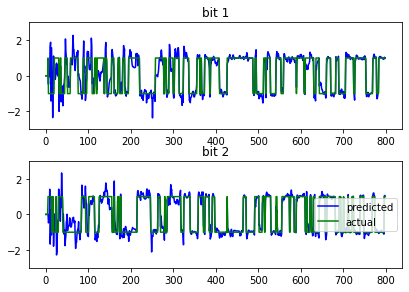

testing loss: 0.02
testing prediction


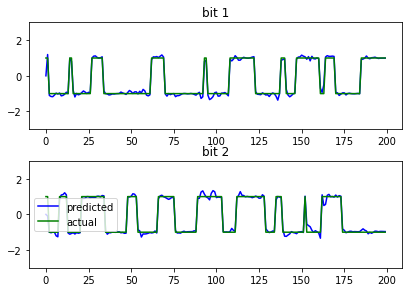

===echo state network with FORCE===
error avg: [0.32858106 0.36380506 0.40984071]
training loss: 0.367
training prediction


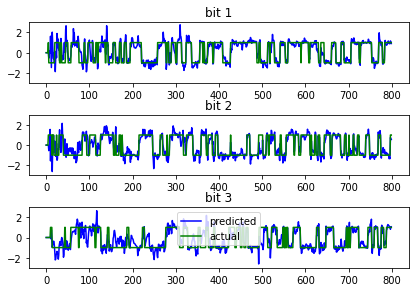

testing loss: 0.119
testing prediction


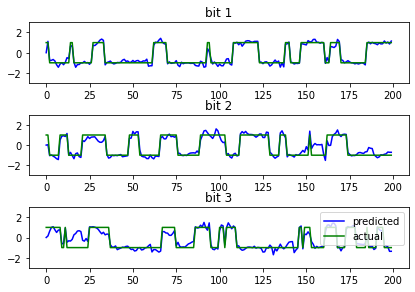

===echo state network with FORCE===
error avg: [0.50748805 0.61901488 0.68348697 0.47957505]
training loss: 0.572
training prediction


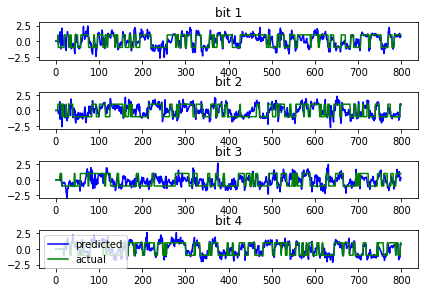

testing loss: 0.441
testing prediction


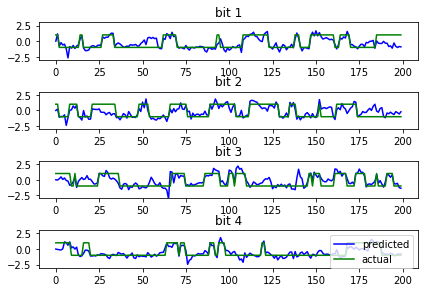

In [ ]:
#@title start training and evaluating ESN with FORCE learning
for num_bits in range(2, 5):
    np.random.seed(42)
    random.seed(42)
    input_size = num_bits
    output_size = num_bits
    X_train, Y_train, X_test, Y_test = create_dataset(num_bits)
    print(f'===echo state network with FORCE===')
    input_weights = np.random.uniform(-0.5, 0.5, [reservoir_neurons, input_size])
    re_weights = np.random.uniform(-0.5, 0.5, [reservoir_neurons, reservoir_neurons])
    feedback_weights = np.random.uniform(-0.5, 0.5, [reservoir_neurons, output_size])

    # sparsity
    re_weights[np.random.rand(*re_weights.shape) > p] = 0.0
    re_weights = re_weights * g * scale

    # training
    Wout, predictions, training_loss = fit_force(X_train, Y_train, input_weights, re_weights, feedback_weights)
    fig, ax = plt.subplots(num_bits)
    fig.tight_layout()
    if num_bits == 1:
        ax = [ax]
    print(f'training loss: {np.round(np.mean(training_loss), 3)}')
    print(f'training prediction')
    for i in range(num_bits):
      ax[i].set_title(f'bit {i+1}')
      predict_plot = ax[i].plot(range(X_train.shape[0]), predictions[:, i], color='b', label='predicted')
      orig_plot = ax[i].plot(range(X_train.shape[0]), Y_train[:, i], color='g', label='actual')
      ax[i].set_ylim([-3, 3])
    plt.legend()
    plt.savefig(f'training with force: number of bits is {num_bits}')
    plt.show()

    # testing
    predictions, test_loss = predict_force(X_test, Y_test, input_weights, re_weights, feedback_weights, Wout)
    fig, ax = plt.subplots(num_bits)
    fig.tight_layout()
    if num_bits == 1:
        ax = [ax]
    print(f'testing loss: {np.round(np.mean(test_loss), 3)}')
    print(f'testing prediction')
    for i in range(num_bits):
      ax[i].set_title(f'bit {i+1}')
      predict_plot = ax[i].plot(range(X_test.shape[0]), predictions[:, i], color='b', label='predicted')
      orig_plot = ax[i].plot(range(X_test.shape[0]), Y_test[:, i], color='g', label='actual')
      ax[i].set_ylim([-3, 3])
    plt.legend()
    plt.savefig(f'testing with force: number of bits is {num_bits}')
    plt.show()


# Evaluation on ESN with FORCE learning

---


Without changing much implementation from the ESN without FORCE learning, a modification was made to the training loop and the prediction loop and the functions are renamed as "fit_force" and "predict_force" respectively. 

The way FORCE works is that it allows output errors to flow back into the network during training. The errors are kept small and the weight modifications are made quickly. The errors fed back into weight modification needs to be small enough to prevent disrupting the learning of the echo state network. 

In order for that to happen, a P value is updated during the training phase of the FORCE learning for echo state network as shown here:

<img src="https://i.ibb.co/D7H0Rwh/Screenshot-2021-04-18-at-9-58-26-PM.png" width="400"/>

The initial value of P would be: 

<img src="https://i.ibb.co/cvtNSNW/Screenshot-2021-04-18-at-9-58-32-PM.png" width="200" />

where alpha is a hyperparameter that can be tuned.

P is a running estimate of the inverse correlation matrix of the network:

<img src="https://i.ibb.co/wC68b18/Screenshot-2021-04-18-at-9-58-40-PM.png" width="400" />

where r is the state. 

we know that the original echo state network update is:

W = (R^T R + lambda * I) ^-1 * R * t

where t is the target. Now since P is a running estimate of the inverse correlation matrix, we can then write the weight update as follows:
 
 <img src="https://i.ibb.co/tsmRNy7/Screenshot-2021-04-18-at-10-13-04-PM.png" width="400" /> 

 e_(t) is the difference between the output of the echo state network and the target value. Since e_(t) can be an approximate representation of t in the original esn equation. The equation therefore can be used to slowly fix the weight to the optimal weight through e_(t) and P matrix. 

---

Another hyperparameter that is tunable in FORCE echo state network is the g value which is used to scale the echo state network initial weights. The paper shows that g value > 1 exhibits chaotic network activity and network that exhibits chaotic activity initially are quicker to train.

In this analysis, 
The g hyperparameter is changed to determine if there is any improvement in performance.

**tested on 2 bits flip-flop task**

| p | g | scale | training loss | testing loss |
| :- | :- | :- | :- | :- |
|0.2 | 0.8 |	0.7 |	0.37 |	1.072 |
|0.2 | 0.8 |	0.8 |	0.368 |	1.218 |
|0.3 | 0.8 |	0.7 |	0.371 |	1.145 |
|0.5 | 0.8 |	0.7 |	0.363 |	1.282 |
|0.4 | 0.8 |	0.7 |	0.373 |	1.092 |
|0.4 | 0.8 |	0.8 |	0.362 |	2.42 |
|0.4 | 0.7 |	0.7 |	0.37 |	1.012 |


There is not much improvement in training or testing loss with varying g hyperparameter. Reading back at the paper, they showed that with g > 1 learning works best. The network that are in chaotic state initially train quicker and create more accurate prediction. The author showed that there is an upper limit for g where chaos cannot be surpressed by FORCE learning. The best value for g is the value right below the value where FORCE fails to surpress the chaotic state during training.

With that, g is set to 2 for this dataset. However, the performance of the network for both training and testing does not seem to be having any improvement. 

The plots for the normal ESN network is as follows:

**training**

<img src="https://i.ibb.co/kDgw5B9/all-training-with-force.png" width="400"/>

**testing**

<img src="https://i.ibb.co/KqBcfb0/all-testing-with-force.png" width="400" />


It does seem like the echo state network is lacking in some way. I realised that since dt is 1 for the flip-flop dataset, the equation for setting the x from the implementation should be:

`x = -(1-dt)x + weighted_input @ inputs + weighted_state @ state + weighted_fb @ fb`

which is equivalent to:

`x = weighted_input @ inputs + weighted_state @ state + weighted_fb @ fb`


An analysis of different hyperparameters of g and alpha are then plotted on the table below:

**g hyperparameter, alpha set as 1**

| num bits | g | training loss | testing loss |
| :- | :- | :- | :- |
| 2 | 0.1 | 0.136 | 0.012 |
| 3 | 0.1 | 0.243 | 0.043 |
| 4 | 0.1 | 0.426 | 0.199 |
| | | |
| 2 | 1 | 0.153 | 0.014 |
| 3 | 1 | 0.26 | 0.073 |
| 4 | 1 | 0.47 | 0.306 |
| | | |
| 2 | 1.5 | 0.142 | 0.015 |
| 3 | 1.5 | 0.247 | 0.093 |
| 4 | 1.5 | 0.448 | 0.364 |
| | | |
| 2 | 2 | 0.145 | 0.02 |
| 3 | 2 | 0.275 | 0.119 |
| 4 | 2 | 0.542 | 0.441 |

It seems like g with values of 0.1 have the best performance. Even though the paper stated that the network with chaotic activity in the beginning performs the best. However, in this dataset it seems that g with 0.1 provides the best performance regardless of how quickly the network trains intially. g with value of 0.1 will be used to test the alpha hyperparameters:

**alpha hyperparameter, g set as 0.1**

| num bits | alpha | training loss | testing loss |
| :- | :- | :- | :- |
| 2 | 0.1 | 0.301 | 0.014 |
| 3 | 0.1 | 0.847 | 0.205 |
| 4 | 0.1 | 1.577 | 0.555 |
| | | |
| 2 | 0.5 | 0.131 | 0.013 |
| 3 | 0.5 | 0.3 | 0.053 |
| 4 | 0.5 | 0.681 | 0.285 |
| | | |
| 2 | 0.8 | 0.134 | 0.011 |
| 3 | 0.8 | 0.271 | 0.047 |
| 4 | 0.8 | 0.471 | 0.307 |
| | | |
| 2 | 1 | 0.136 | 0.012 |
| 3 | 1 | 0.243 | 0.043 |
| 4 | 1 | 0.426 | 0.199 |
| | | |
| 2 | 2 | 0.14 | 0.013 |
| 3 | 2 | 0.221 | 0.053 |
| 4 | 2 | 0.402 | 0.247 |
| | | |
| 2 | 5 | 0.186 | 0.026 |
| 3 | 5 | 0.288 | 0.074 |
| 4 | 5 | 0.42 | 0.286 | 

The analysis shows that the test performance of ESN with FORCE learning achieves the best performance overally. when the alpha value is 1. 

There is one more step we can improve the test performance. We can see that the training performance is more than 0.1 for all the number of bits. This shows that the echo state network is underfitting/bias. We can alleviate this issue by increase the model size. Let's increase the reservoir neuron size to 2000 and see the results. The alpha and g will be set as 1 and as they are the best performing hyperparameter.

| num bits | g | alpha | reservoir neurons | training loss | testing loss |
| :- | :- | :- | :- | :- | :- |
| 2 | 0.1 | 1 | 1000 | 0.136 | 0.012 |
| 3 | 0.1 | 1 | 1000 | 0.243 | 0.043 |
| 4 | 0.1 | 1 | 1000 | 0.426 | 0.199 |
| | | | | | | 
| 2 | 0.1 | 1 | 2000 | 0.154 | 0.01 |
| 3 | 0.1 | 1 | 2000 | 0.406 | 0.051 |
| 4 | 0.1 | 1 | 2000 | 0.55 | 0.229 |

It does not seem like increasing the resrvoir neuron improve the performance of the test performance either. The best performing hyperparameters are:
- g: 0.1
- alpha: 1
- reservoir neurons: 1000
- test loss: 0.012, 0.043, 0.199

The paper stated that g should be more than 1 and works best on that condition. However it seems like the experiment that was conducted here shows that g performs the best on the testing performance when the g value is 0.1.  

The plot for the best performing hyperparameter can be seen here:

**training plot**

<img src="https://i.ibb.co/ct9BLGK/all-training-with-force.png" width="400" />

**testing plot**

<img src="https://i.ibb.co/7VKpwnR/all-testing-with-force.png" width="400" />
